In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 68

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 9

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/200


 67/100 [===================>..........] - ETA: 0s - loss: 2.0832 - accuracy: 0.2306
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
100/100 [==============================] - 2s 6ms/step - loss: 1.9975 - accuracy: 0.2778 - val_loss: 1.6575 - val_accuracy: 0.4543


d:\Projects\VocalWave\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
 98/100 [============================>.] - ETA: 0s - loss: 1.5282 - accuracy: 0.4529
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
100/100 [==============================] - 0s 3ms/step - loss: 1.5267 - accuracy: 0.4531 - val_loss: 1.2055 - val_accuracy: 0.6241
Epoch 3/200
 71/100 [====================>.........] - ETA: 0s - loss: 1.2498 - accuracy: 0.5397
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
100/100 [==============================] - 0s 2ms/step - loss: 1.2168 - accuracy: 0.5510 - val_loss: 0.8975 - val_accuracy: 0.7116
Epoch 4/200
 72/100 [====================>.........] - ETA: 0s - loss: 1.0501 - accuracy: 0.6042
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
100/100 [==============================] - 0s 2ms/step - loss: 1.0339 - accuracy: 0.6100 - val_loss: 0.7174 - val_accuracy: 0.8338
Epoch 5/200
 87/100 [=========================>....] - ETA: 0s - loss: 0.9144 - accuracy

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

25/25 [==============================] - 0s 1ms/step - loss: 0.0875 - accuracy: 0.9839


In [13]:
# Loading the saved model
# model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 78ms/step
[2.4959986e-19 1.8200823e-04 1.5680961e-23 8.4081996e-04 9.9897718e-01
 3.6447712e-08 1.8564866e-15 5.8085492e-13 5.1960058e-09]
4


# Confusion matrix

100/100 [==============================] - 0s 996us/step


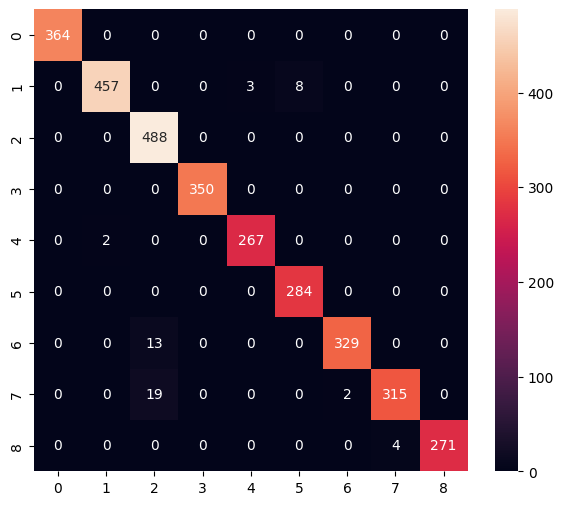

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.98      0.99       468
           2       0.94      1.00      0.97       488
           3       1.00      1.00      1.00       350
           4       0.99      0.99      0.99       269
           5       0.97      1.00      0.99       284
           6       0.99      0.96      0.98       342
           7       0.99      0.94      0.96       336
           8       1.00      0.99      0.99       275

    accuracy                           0.98      3176
   macro avg       0.99      0.98      0.98      3176
weighted avg       0.98      0.98      0.98      3176



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

d:\Projects\VocalWave\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\kawan\AppData\Local\Temp\tmpg75jkt8l\assets


INFO:tensorflow:Assets written to: C:\Users\kawan\AppData\Local\Temp\tmpg75jkt8l\assets


6764

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.4960079e-19 1.8200821e-04 1.5680960e-23 8.4082072e-04 9.9897718e-01
 3.6447712e-08 1.8564864e-15 5.8085378e-13 5.1960058e-09]
4
